## me ubico en el directorio

In [2]:
import os

In [3]:
carpetaActual   = os.getcwd()
print(carpetaActual)


/Users/maxiabdala/Documents/python/series_temporales_maxi/trabajo_final


In [4]:
os.chdir('audiosClasificadosVideo1')
print(os.getcwd())

/Users/maxiabdala/Documents/python/series_temporales_maxi/trabajo_final/audiosClasificadosVideo1


In [6]:
import os
import librosa
import numpy as np

# Directorio actual
current_dir = os.getcwd()

# Lista de etiquetas y nombres de archivos
etiquetas = ['auto', 'moto', 'camioneta', 'colectivo']
nombres_archivos = os.listdir(current_dir)

# Inicializar listas para almacenar los datos de audio y las etiquetas
datos = []
etiquetas_datos = []

# Duración objetivo de los audios (en segundos)
duracion_objetivo = 2

# Iterar sobre los archivos en el directorio
for archivo in nombres_archivos:
    # Cargar el archivo de audio
    ruta_archivo = os.path.join(current_dir, archivo)
    audio, sr = librosa.load(ruta_archivo, sr=None)
    
    # Recortar el audio a la duración objetivo
    duracion_actual = librosa.get_duration(y=audio, sr=sr)
    if duracion_actual >= duracion_objetivo:
        audio_recortado = audio[:int(duracion_objetivo * sr)]
    else:
        # Si el audio es más corto que la duración objetivo, rellenar con ceros
        audio_recortado = np.pad(audio, (0, int((duracion_objetivo - duracion_actual) * sr)), 'constant')
    
    # Agregar audio recortado y etiqueta a las listas
    datos.append(audio_recortado)
    for i, etiqueta in enumerate(etiquetas):
        if etiqueta in archivo:
            etiquetas_datos.append(i)
            break

# Convertir listas a matrices numpy
datos = np.array(datos)
etiquetas_datos = np.array(etiquetas_datos)

# Ahora tienes tus datos de audio recortados en la matriz "datos" y las etiquetas en "etiquetas_datos"
# Puedes usarlos para crear tu conjunto de entrenamiento y realizar otras operaciones, como generar espectrogramas.


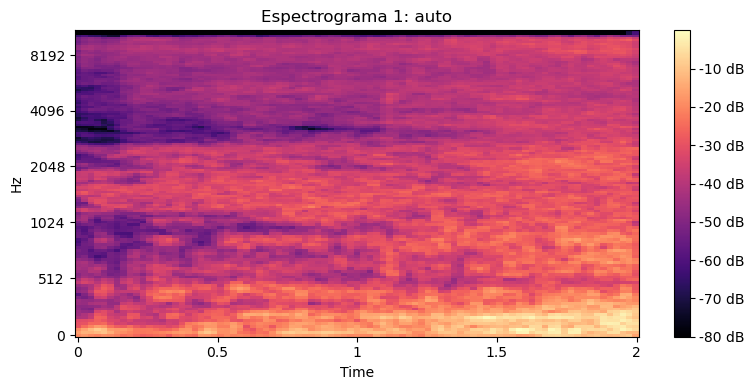

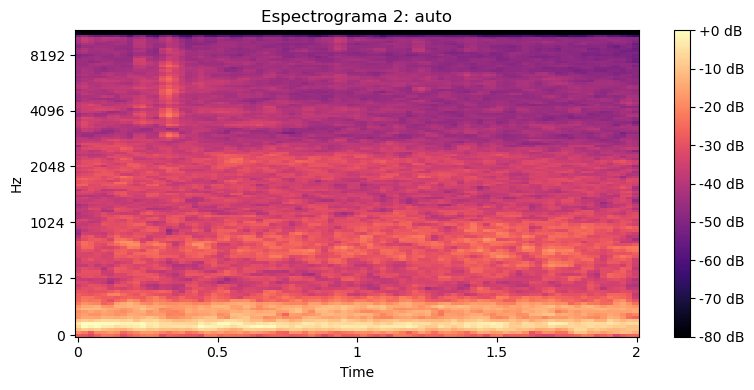

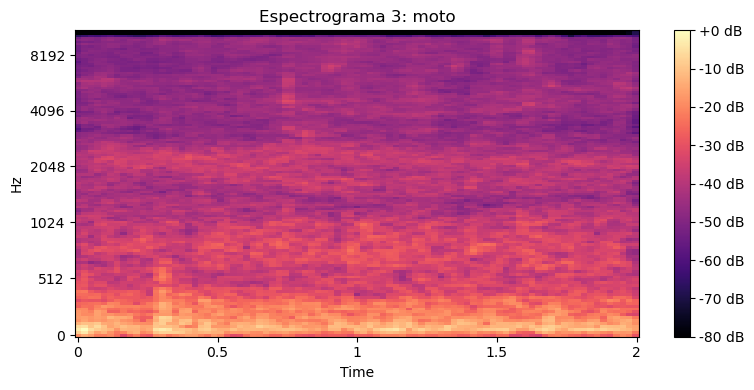

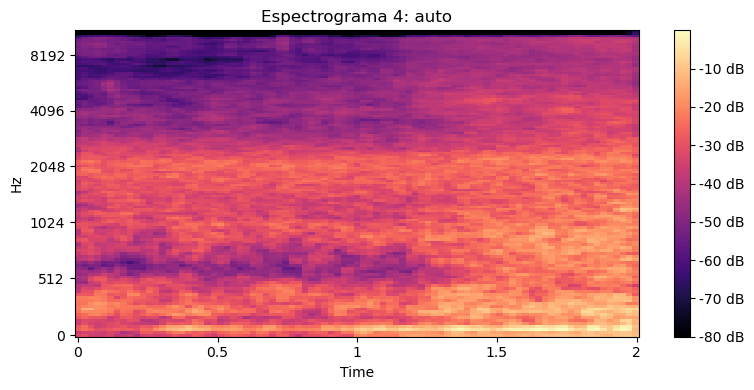

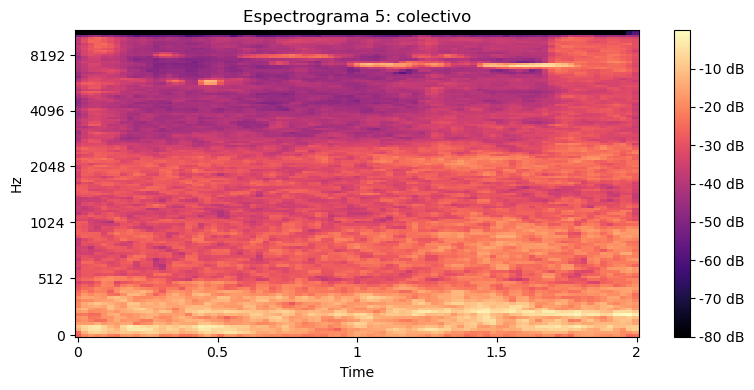

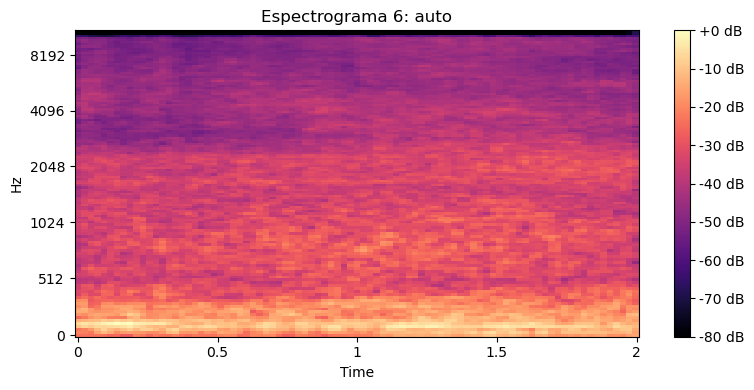

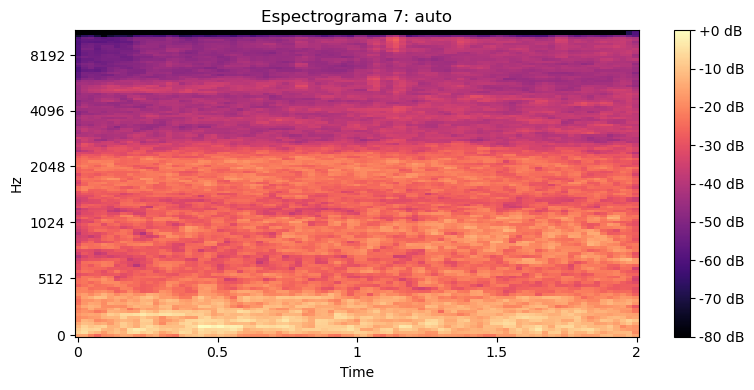

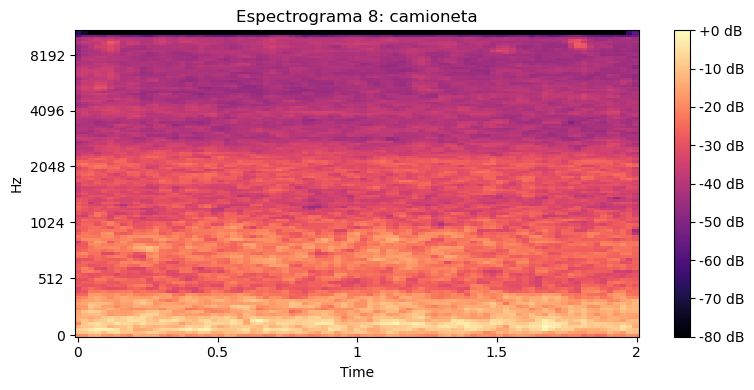

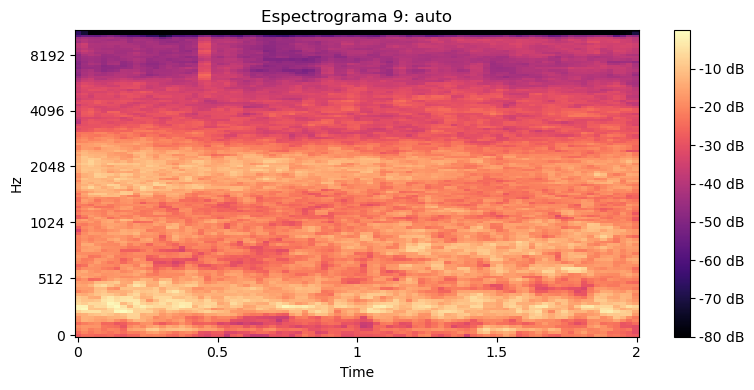

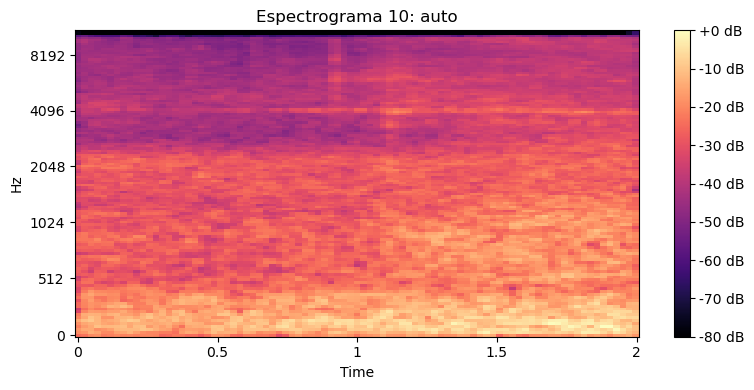

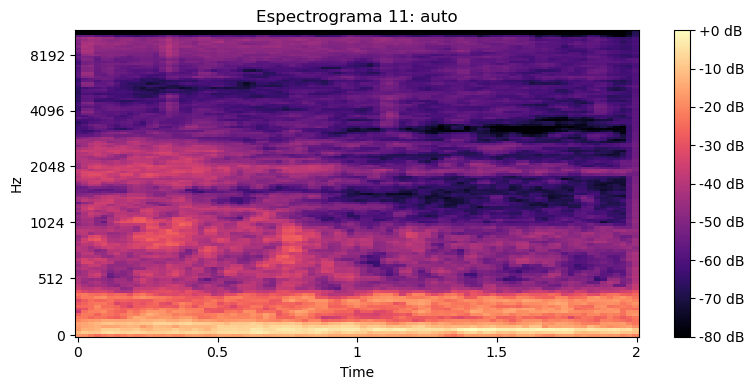

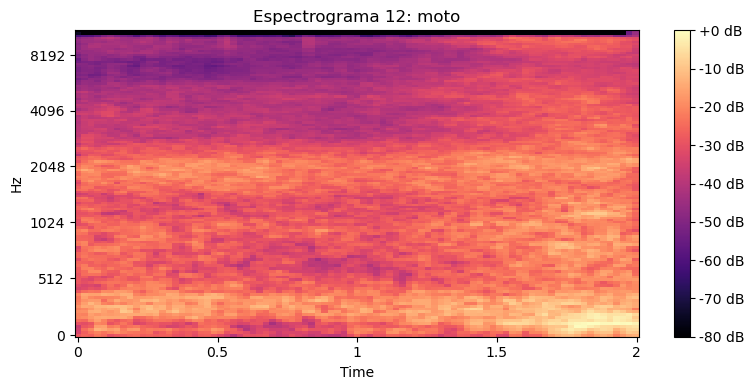

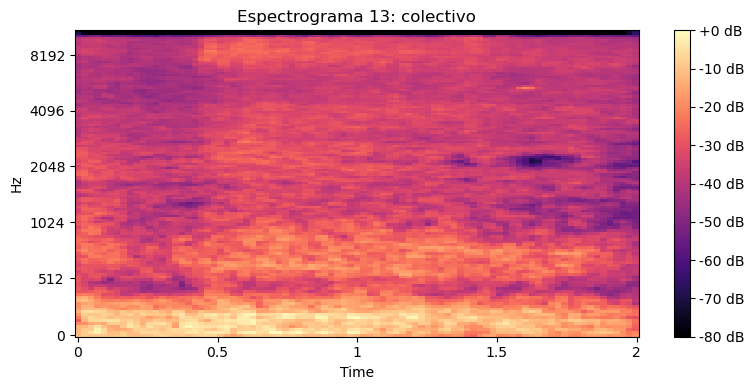

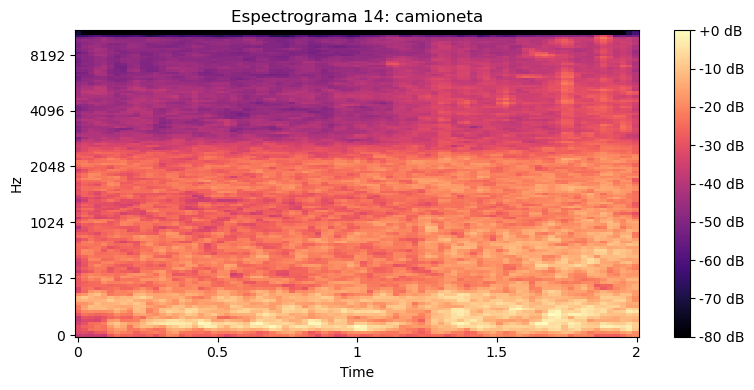

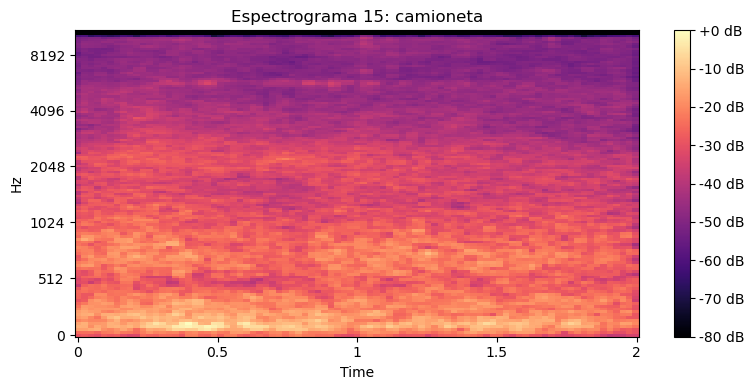

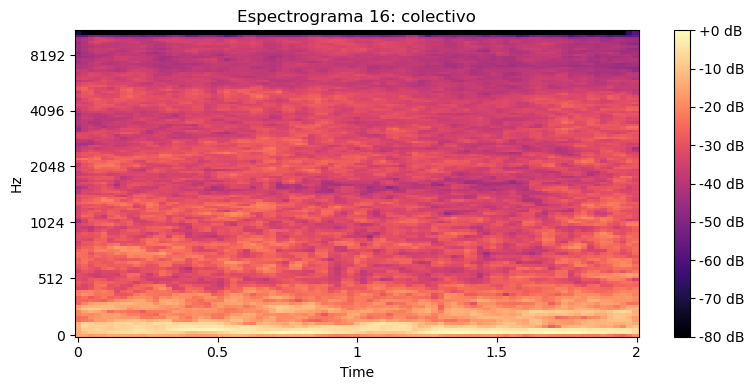

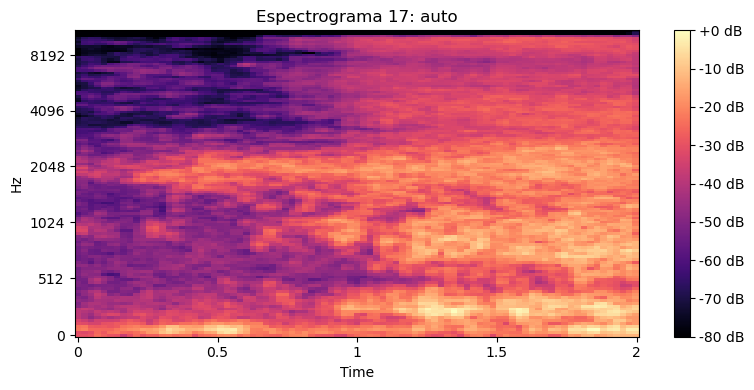

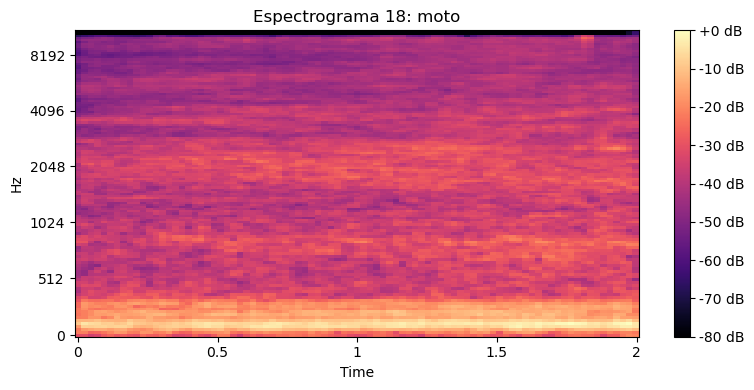

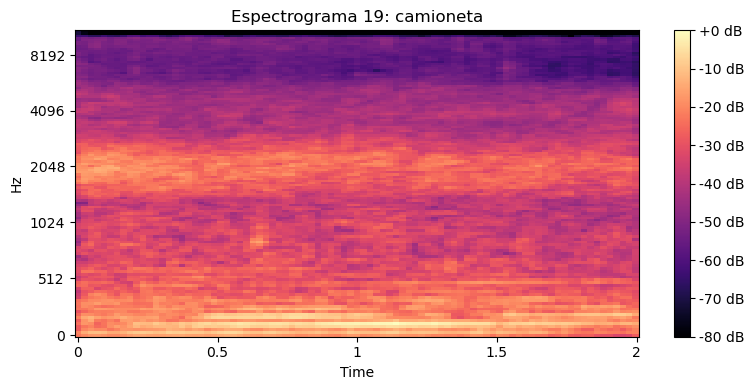

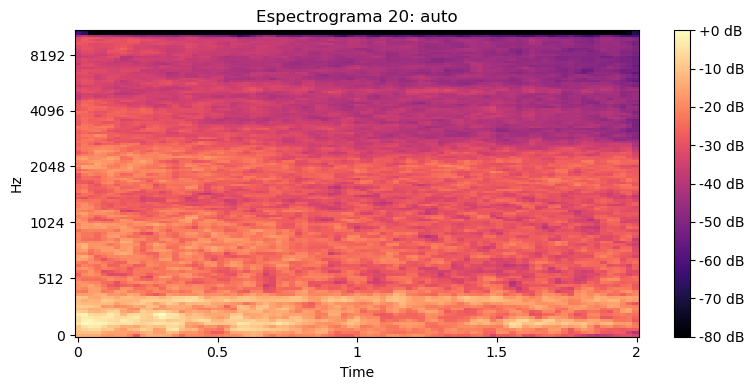

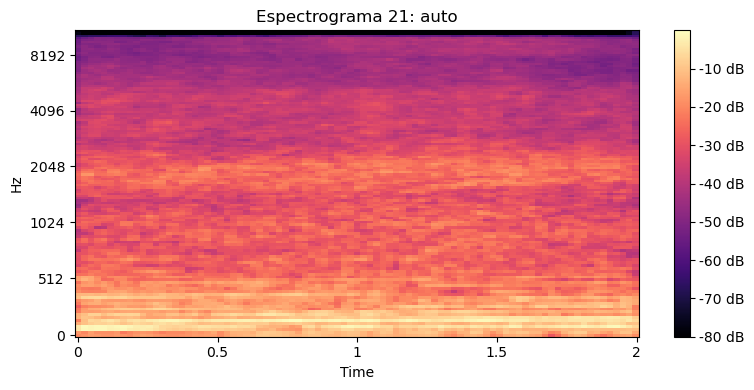

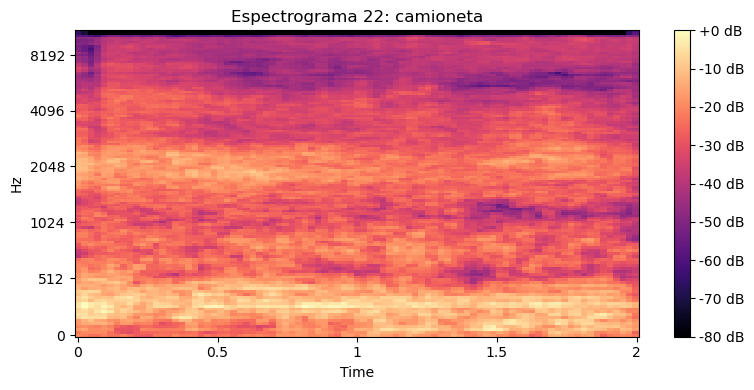

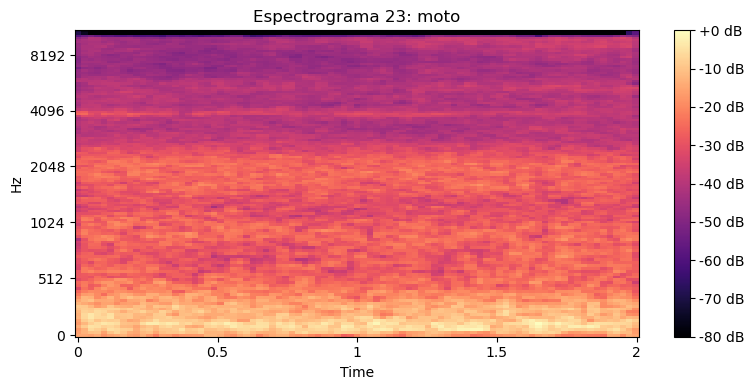

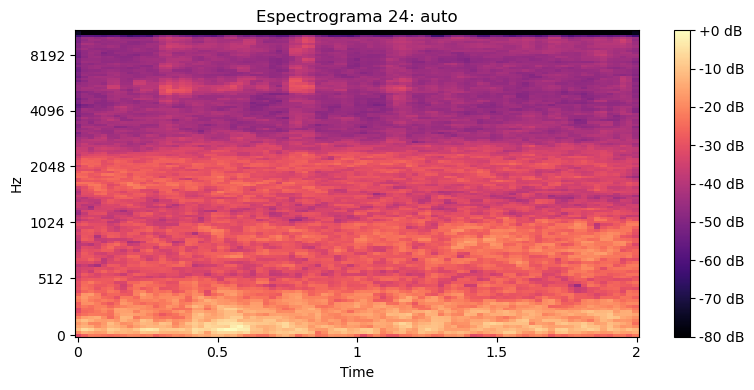

In [9]:
import librosa.display
import matplotlib.pyplot as plt

# Suponiendo que "datos" es la matriz que contiene los datos de audio recortados
# y "sr" es la tasa de muestreo utilizada para grabar los audios (obtenida anteriormente)

# Parámetros para el espectrograma
n_fft = 2048  # Tamaño de la ventana de la transformada de Fourier de corto tiempo (STFT)
hop_length = 512  # Desplazamiento entre ventanas sucesivas en la STFT
n_mels = 128  # Número de bandas Mel
fmin = 20  # Frecuencia mínima de la escala Mel
fmax = sr // 2  # Frecuencia máxima de la escala Mel (la mitad de la tasa de muestreo)

# Generar espectrogramas para cada audio
espectrogramas = []
for audio in datos:
    # Calcular el espectrograma mel
    mel_espectrograma = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                       n_mels=n_mels, fmin=fmin, fmax=fmax)
    
    # Convertir a decibeles (escala logarítmica)
    mel_espectrograma_db = librosa.power_to_db(mel_espectrograma, ref=np.max)
    
    # Agregar el espectrograma a la lista
    espectrogramas.append(mel_espectrograma_db)

for i, (espectrograma, etiqueta) in enumerate(zip(espectrogramas, etiquetas_datos)):
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(espectrograma, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')  # Agregar barra de color
    plt.title(f'Espectrograma {i+1}: {etiquetas[etiqueta]}')  # Título del espectrograma con la etiqueta correspondiente
    plt.tight_layout()
    plt.show()  # Mostrar el espectrograma en una gráfica individual


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir la arquitectura de la red neuronal
def crear_modelo(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')  # 4 clases: auto, moto, camioneta, colectivo
    ])
    return model

# Crear el modelo
input_shape = (espectrogramas[0].shape[0], espectrogramas[0].shape[1], 1)  # Formato del espectrograma
modelo = crear_modelo(input_shape)

# Compilar el modelo
modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Convertir los espectrogramas a un formato adecuado para la entrada de la red neuronal
espectrogramas_reshaped = np.array([espectrograma[..., np.newaxis] for espectrograma in espectrogramas])

# Entrenar el modelo
modelo.fit(espectrogramas_reshaped, etiquetas_datos, epochs=40, validation_split=0.2)

# Guardar el modelo entrenado para su uso posterior
modelo.save('modelo_vehiculos.h5')


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 4.4159 - accuracy: 0.2632 - val_loss: 16.3170 - val_accuracy: 0.2000
Epoch 2/40
1/1 [==============================] - 0s 214ms/step - loss: 23.5004 - accuracy: 0.3158 - val_loss: 11.2796 - val_accuracy: 0.2000
Epoch 3/40
1/1 [==============================] - 0s 209ms/step - loss: 14.4538 - accuracy: 0.1053 - val_loss: 3.6813 - val_accuracy: 0.0000e+00
Epoch 4/40
1/1 [==============================] - 0s 205ms/step - loss: 4.7457 - accuracy: 0.4211 - val_loss: 1.2544 - val_accuracy: 0.6000
Epoch 5/40
1/1 [==============================] - 0s 199ms/step - loss: 1.7543 - accuracy: 0.3158 - val_loss: 1.8515 - val_accuracy: 0.2000
Epoch 6/40
1/1 [==============================] - 0s 205ms/step - loss: 2.8764 - accuracy: 0.2105 - val_loss: 1.1647 - val_accuracy: 0.6000
Epoch 7/40
1/1 [==============================] - 0s 198ms/step - loss: 1.7938 - accuracy: 0.3684 - val_loss: 1.3550 - val_accuracy: 0.6000
Epoch 8/40
1/1 

In [13]:
os.chdir('..')
print(os.getcwd())

/Users/maxiabdala/Documents/python/series_temporales_maxi/trabajo_final


In [18]:
import numpy as np
from tensorflow.keras.models import load_model
from skimage.transform import resize

# Función para cargar y procesar un audio
def procesar_audio(ruta_audio, duracion_segmento=2, sr=None):
    # Cargar el audio
    audio, sr = librosa.load(ruta_audio, sr=sr)
    
    # Dividir el audio en segmentos de 2 segundos
    longitud_segmento = duracion_segmento * sr
    segmentos_audio = []
    for i in range(0, len(audio), longitud_segmento):
        segmento = audio[i:i+longitud_segmento]
        if len(segmento) < longitud_segmento:
            segmento = np.pad(segmento, (0, max(0, longitud_segmento - len(segmento))), mode='constant')
        segmentos_audio.append(segmento)
    
    # Generar espectrogramas para cada segmento de audio
    espectrogramas_nuevo_audio = []
    for segmento in segmentos_audio:
        # Calcular el espectrograma mel
        espectrograma = librosa.feature.melspectrogram(y=segmento, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=sr // 2)
        espectrograma_db = librosa.power_to_db(espectrograma, ref=np.max)
        espectrogramas_nuevo_audio.append(espectrograma_db)
    
    # Redimensionar todos los espectrogramas al mismo tamaño esperado por el modelo (128, 87)
    espectrogramas_nuevo_audio = [resize(espectrograma, (128, 87), mode='constant') for espectrograma in espectrogramas_nuevo_audio]
    
    return np.array(espectrogramas_nuevo_audio)

# Cargar el modelo entrenado
modelo = load_model('modelo_vehiculos.h5')

# Procesar el nuevo audio
ruta_audio = 'audio2.mp3'
espectrogramas_nuevo_audio = procesar_audio(ruta_audio)

# Añadir una dimensión adicional para el canal de color
espectrogramas_reshaped = espectrogramas_nuevo_audio[..., np.newaxis]

# Realizar la predicción con el modelo
predicciones = modelo.predict(espectrogramas_reshaped)

# Obtener la clase predicha para cada segmento
clases_predichas = np.argmax(predicciones, axis=1)

# Obtener la clase mayoritaria en el audio completo
clase_final = np.bincount(clases_predichas).argmax()

# Mapear la clase a la etiqueta correspondiente
etiquetas = ['auto', 'moto', 'camioneta', 'colectivo']
vehiculo_detectado = etiquetas[clase_final]

print(f"El vehículo detectado en el audio es: {vehiculo_detectado}")


3/3 [==============================] - 0s 27ms/step
El vehículo detectado en el audio es: auto


In [19]:

# Función para cargar y procesar un audio
def procesar_audio(ruta_audio, duracion_segmento=2, sr=None):
    # Cargar el audio
    audio, sr = librosa.load(ruta_audio, sr=sr)
    
    # Dividir el audio en segmentos de 2 segundos
    longitud_segmento = duracion_segmento * sr
    segmentos_audio = []
    for i in range(0, len(audio), longitud_segmento):
        segmento = audio[i:i+longitud_segmento]
        if len(segmento) < longitud_segmento:
            segmento = np.pad(segmento, (0, max(0, longitud_segmento - len(segmento))), mode='constant')
        segmentos_audio.append(segmento)
    
    # Generar espectrogramas para cada segmento de audio
    espectrogramas_nuevo_audio = []
    for segmento in segmentos_audio:
        espectrograma = librosa.feature.melspectrogram(y=segmento, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=sr // 2)
        espectrograma_db = librosa.power_to_db(espectrograma, ref=np.max)
        espectrogramas_nuevo_audio.append(espectrograma_db)
    
    # Redimensionar todos los espectrogramas al mismo tamaño esperado por el modelo (128, 87)
    espectrogramas_nuevo_audio = [resize(espectrograma, (128, 87), mode='constant') for espectrograma in espectrogramas_nuevo_audio]
    
    return np.array(espectrogramas_nuevo_audio)

# Cargar el modelo entrenado
modelo = load_model('modelo_vehiculos.h5')

# Procesar el nuevo audio
ruta_audio = 'audio2.mp3'
espectrogramas_nuevo_audio = procesar_audio(ruta_audio)

# Añadir una dimensión adicional para el canal de color
espectrogramas_reshaped = espectrogramas_nuevo_audio[..., np.newaxis]

# Realizar la predicción con el modelo
predicciones = modelo.predict(espectrogramas_reshaped)

# Obtener la clase predicha para cada segmento
clases_predichas = np.argmax(predicciones, axis=1)

# Contar la cantidad de cada clase predicha
conteo_clases = np.bincount(clases_predichas, minlength=4)

# Mapear los conteos a las etiquetas correspondientes
etiquetas = ['auto', 'moto', 'camioneta', 'colectivo']
conteo_vehiculos = {etiqueta: conteo for etiqueta, conteo in zip(etiquetas, conteo_clases)}

# Imprimir los resultados
for vehiculo, conteo in conteo_vehiculos.items():
    print(f"{vehiculo}: {conteo}")


3/3 [==============================] - 0s 27ms/step
auto: 65
moto: 0
camioneta: 0
colectivo: 0
